In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def inspect_pixels(tpf, normalized=False, periodogram=False, aperture_mask=None, **kwargs):
    # tpf to be replaced with self
    """ Plot the light curves or associated periodograms for each pixel in one quarter
    
    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        A matplotlib axes object to plot into. If no axes is provided,
        a new one will be generated.
    normalized : bool
        Default: False; if True, the normalized light curves will be plotted.
    periodogram : bool
        Default: False; if True, periodograms will be plotted, using normalized light curves.
        Note that this keyword overrides normalized.
    aperture_mask : ndarray or str
        Highlight pixels selected by aperture_mask.
        Only `pipeline`, `threshold`, or custom masks will be plotted.
        `all` and None masks will be ignored.
    kwargs : dict
        e.g. `threshold` to be passed to create_threshold_mask
    
    """
    
    # get an aperture mask for each pixel
    masks = np.zeros((tpf.shape[1]*tpf.shape[2], tpf.shape[1], tpf.shape[2]), dtype='bool')
    for i in range(tpf.shape[1]*tpf.shape[2]):
        masks[i][np.unravel_index(i, (tpf.shape[1], tpf.shape[2]))] = True
    
    pixel_list = []

    for j in range(tpf.shape[1]*tpf.shape[2]):
        lc = tpf.to_lightcurve(aperture_mask=masks[j])
        lc_norm = lc.normalize().remove_outliers()
        if periodogram == True:
            try:
                pixel_list.append(lc_norm.to_periodogram())
            except IndexError:
                pixel_list.append(None)
        else:
            if normalized == True:
                if len(lc_norm.remove_nans().flux) == 0:
                    pixel_list.append(None)
                else:
                    pixel_list.append(lc_norm)
            elif normalized == False:
                if len(lc.remove_nans().flux) == 0:
                    pixel_list.append(None)
                else:
                    pixel_list.append(lc)
                
    if aperture_mask == 'pipeline':
        mask = tpf.pipeline_mask
    elif aperture_mask == 'threshold':
        mask = tpf.create_threshold_mask(**kwargs)
    elif aperture_mask == 'all' or aperture_mask == None:
        mask = np.zeros((tpf.shape[1], tpf.shape[2]), dtype='bool')
    else:
        mask = aperture_mask

    fig = plt.figure()
    ax0 = plt.gca()
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])

    gs = gridspec.GridSpec(tpf.shape[1], tpf.shape[2], wspace=0, hspace=0)

    for k in range(tpf.shape[1]*tpf.shape[2]):
        if pixel_list[k] != None:
            x, y = np.unravel_index(k, (tpf.shape[1], tpf.shape[2]))
            ax = fig.add_subplot(gs[tpf.shape[1] - x - 1,y])

            if periodogram == True:
                x_vals = pixel_list[k].frequency.value
                y_vals = pixel_list[k].power.value
            elif periodogram == False:
                x_vals = pixel_list[k].time
                y_vals = pixel_list[k].flux

            if mask[x,y] == True:
                lower = np.zeros(len(x_vals)) + np.nanmin(y_vals)
                upper = np.zeros(len(x_vals)) + np.nanmax(y_vals)
                ax.fill_between(x_vals, lower, upper, facecolor='#ff99a3')

            ax.plot(x_vals, y_vals, lw=0.5, c='k')
            ax.set_xlim(np.nanmin(x_vals), np.nanmax(x_vals))
            ax.set_ylim(np.nanmin(y_vals), np.nanmax(y_vals))
            ax.set_xticklabels('')
            ax.set_yticklabels('')
            ax.set_xticks([])
            ax.set_yticks([])

In [3]:
kic = 7461601
q = 9
cadence = 'long'

In [4]:
tpf = lk.search_targetpixelfile(f'KIC {kic}', quarter=q, cadence=cadence).download()

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
<string>:6: RuntimeWarning: Degrees of freedom <= 0 for slice.
/usr/local/lib/python3.7/site-packages/lightkurve-2.0.dev0-py3.7.egg/lightkurve/lightcurve.py:703: LightkurveWarning: The light curve appears to be zero-centered (median=-1.80e+00 electron / s +/- 4.78e+00 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning)
/usr/local/lib/python3.7/site-packages/lightkurve-2.0.dev0-py3.7.egg/lightkurve/lightcurve.py:711: LightkurveWarning: The light curve has a negative median flux (-1.80e+00 electron / s); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
/usr/local/lib/python3.7/site-packages/lightkurve-2.0.dev0-py3.7.egg/lightkurve/lightcurve.py:7

ValueError: setting an array element with a sequence.

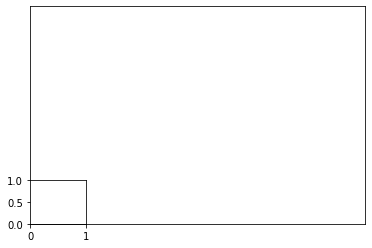

In [5]:
inspect_pixels(tpf, normalized=False, periodogram=False, aperture_mask='threshold', threshold=2)

In [ ]:
inspect_pixels(tpf, normalized=True, periodogram=False, aperture_mask='pipeline')

In [ ]:
inspect_pixels(tpf, periodogram=True, aperture_mask='pipeline')